# Toy neural network example

We train a neural network giving for u in <0,1> a point (x,y) with coordinates 

$x = cos(2\pi u)$

$y = sin(2\pi u)$

that is, a point on a unit circle. The network will work as a random "transformer", transforming a random u in <0,1> to a random point on a unit circle. 

# Tasks:
### 1. Study the code.
There are several things that can be new:
- numpy arrays: notice how we can operate on arrays - square them, take a sine or cosine, reshape them
- pandas dataframes: notice how we can pack several arrays into a data table - a pandas DataFrame.
- matplotlib plots: notice how simply we plot things, and
- seaborn plots that add some more plotting functionality.

### 2. Study the neural network.
- Training data. To train a neural network, we have to have a proper sample of training data. In this case, it is very simple to generate them. See what happens when you use a smaller or larger training sample.
- Hyperparameters. We have some freedom in selecting how the network looks (sizes of hidden layers) and how we train it. Look into scikit-learn documentation (google "scikit learn MLPRegressor") and experiment with various combinations of hyperparameters. Optimize training data size and hyperparameters to achieve best precision.
Rules for hidden layers: 
(i) In theory, a neural network with a single layer can represent any mapping between inputs and outputs (if sufficiently large). 
(ii) If the problem is strongly non-linear, then a two-layer network can be easier to train. 
(iii) More than two hidden layers are usually unnecessary.

### 3. Investigate the problem.
We need a surprisingly large network and a lot of training data to make the example work.
On the other hand, the training is fairly fast. 

A. Create a network that will produce density proportional to $u(1-u)$ on the unit circle (rather than uniform)

B. (DONE) Create a network that will produce uniform density on an ellipse.

C. Our network has a single input, u. Try to add some orthogonal polynomials (Legendre or Chebyshev) as additional inputs and examine how such networks train.

D. Also, try to extend the training interval for u from <0,1> to some <-d,1+d>. Error is located mostly near 0 and 1, so let us better teach periodicity to the network. 

E. Optimize network parameters and plot optimization results. 

## 0. Includes
Note: 
We can select an alias for the namespace of a particular packages using the "as" clause. However, some aliases are used generally, np for numpy, pd for pandas, plt for matplotlib.pyplot, sns for seaborn. It is not wise to change that.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# seaborn
import seaborn as sns

## 1. Generate data

In [2]:
def make_circle_data(n_samples = 100, overlap = 0.0):
    """Creates pandas dataframe with columns u, x, y, such that u ~ U[0,1], x = cos(2*pi*u), y = sin(2*pi*u)."""
    u = uniform.rvs(-overlap,1+overlap,n_samples) 
    x = np.cos(2*np.pi*u)
    y = np.sin(2*np.pi*u)
    return pd.DataFrame({'u':u, 'x':x, 'y':y})


## 2. Train a network regressor

In [3]:
def train_network(data, test_fraction = 0.1):
    """Returns a trained network object"""
    input_cols = ['u']
    output_cols = ['x','y']
    n_rows = len(data)
    n_test = int(n_rows * test_fraction)
    n_train = n_rows - n_test
    X_train = data[input_cols].values[:n_train]
    X_test = data[input_cols].values[n_train:]
    Y_train = data[output_cols].values[:n_train]
    Y_test = data[output_cols].values[n_train:]
    fitter = MLPRegressor(
                hidden_layer_sizes = (60,60),
                activation = 'relu',
                tol = 1.0e-7,
                alpha = 1.0e-5,
                verbose = False
            )
    fitter.fit(X_train, Y_train)
    print('Fit done. Score: {0}'.format(fitter.score(X_test, Y_test)))
    Y_pred = fitter.predict(X_test)
    rmse = np.sqrt(np.sum((Y_pred - Y_test)**2, axis = 0)/n_test)
    print('RMS error: x {0}, y {1}'.format(rmse[0], rmse[1]))
    return fitter

## 2. Tune network regressor

In [4]:
def tune_network(data, test_fraction = 0.1):
    """Returns a trained network object"""
    input_cols = ['u']
    output_cols = ['x','y']
    n_rows = len(data)
    n_test = int(n_rows * test_fraction)
    n_train = n_rows - n_test
    X_train = data[input_cols].values[:n_train]
    X_test = data[input_cols].values[n_train:]
    Y_train = data[output_cols].values[:n_train]
    Y_test = data[output_cols].values[n_train:]
    fitter0 = MLPRegressor(
                hidden_layer_sizes = (60,60),
                activation = 'logistic',
                tol = 1.0e-7,
                alpha = 1.0e-5,
                verbose = False
            )
    # Optimize for alpha, layer size
    fitter = GridSearchCV(
        fitter0,
        #scoring = 'neg_mean_squared_error',
        param_grid = {
            'alpha': [5.0e-5, 2.0e-5, 1.0e-4, 5.0e-4, 2.0e-4, 1.0e-3],
            'hidden_layer_sizes': [(a, a, a) for a in [20, 25, 30, 35, 40]]
        },
        n_jobs = 4,
        verbose = 1,
    )
    fitter.fit(X_train, Y_train)
    print('Fit done. Score: {0}'.format(fitter.score(X_test, Y_test)))
    Y_pred = fitter.predict(X_test)
    rmse = np.sqrt(np.sum((Y_pred - Y_test)**2, axis = 0)/n_test)
    print('RMS error: x {0}, y {1}'.format(rmse[0], rmse[1]))
    return fitter

## 4. Run and plot results

In [5]:
# Generate samples
samples = make_circle_data(n_samples = 20000)
samples.head()
# Train the network
fitter = tune_network(samples)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  6.2min finished


Fit done. Score: 0.9999942222215641
RMS error: x 0.00202544234975367, y 0.001294353656661538


D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Results: x vs. y

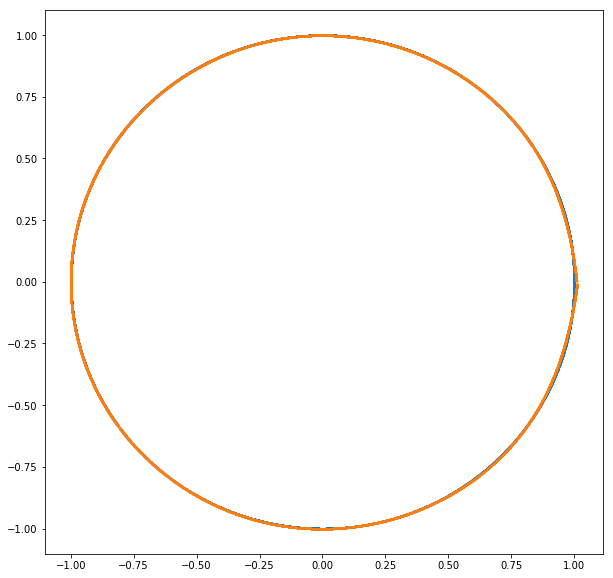

In [6]:
y_pred = fitter.predict(samples.u.values.reshape(-1,1))
fig = plt.figure(figsize = (10,10))
plt.scatter(samples.x,samples.y, s = 0.5)
plt.scatter(y_pred[:,0], y_pred[:,1], s = 0.5)
plt.savefig('../pictures/circle_generator_2d.png')

### Results: x, y vs. u

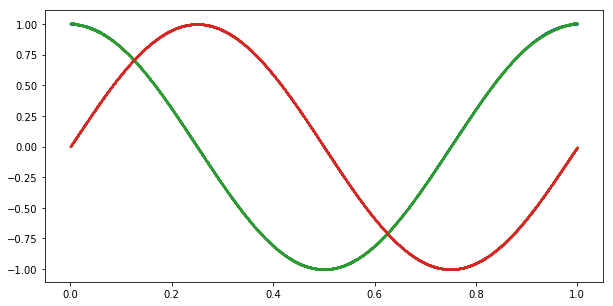

In [7]:
fig = plt.figure(figsize = (10,5))
plt.scatter(samples.u, samples.x, s = 0.2)
plt.scatter(samples.u, samples.y, s = 0.2)
plt.scatter(samples.u, y_pred[:,0], s = 0.2)
plt.scatter(samples.u, y_pred[:,1], s = 0.2)
plt.savefig('../pictures/circle_generator_1d.png')


In [8]:
grid_results = pd.DataFrame(fitter.cv_results_)

In [9]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,13.401426,0.841591,0.010971,8.485379e-07,5e-05,"(20, 20, 20)","{'alpha': 5e-05, 'hidden_layer_sizes': (20, 20...",0.999978,0.999991,0.999978,0.999982,6.054716e-06,12,0.999978,0.999991,0.999977,0.999982,6.341943e-06
1,13.091416,1.188102,0.015957,2.820467e-03,5e-05,"(25, 25, 25)","{'alpha': 5e-05, 'hidden_layer_sizes': (25, 25...",0.999984,0.999979,0.999982,0.999981,2.215808e-06,13,0.999983,0.999979,0.999981,0.999981,1.622451e-06
2,12.694121,0.287673,0.015957,1.184119e-06,5e-05,"(30, 30, 30)","{'alpha': 5e-05, 'hidden_layer_sizes': (30, 30...",0.999981,0.999988,0.999981,0.999983,3.065939e-06,8,0.999981,0.999988,0.999981,0.999983,3.267964e-06
3,14.720538,1.570355,0.018803,2.259036e-04,5e-05,"(35, 35, 35)","{'alpha': 5e-05, 'hidden_layer_sizes': (35, 35...",0.999984,0.999983,0.999990,0.999986,2.900045e-06,4,0.999984,0.999983,0.999990,0.999986,2.873311e-06
4,12.996779,1.664864,0.019947,2.973602e-07,5e-05,"(40, 40, 40)","{'alpha': 5e-05, 'hidden_layer_sizes': (40, 40...",0.999981,0.999982,0.999970,0.999978,5.316863e-06,16,0.999980,0.999983,0.999970,0.999978,5.586984e-06
5,12.309197,0.379501,0.010638,4.694036e-04,2e-05,"(20, 20, 20)","{'alpha': 2e-05, 'hidden_layer_sizes': (20, 20...",0.999983,0.999989,0.999977,0.999983,4.695762e-06,10,0.999983,0.999989,0.999977,0.999983,4.977939e-06
6,12.328693,1.084962,0.013630,4.695721e-04,2e-05,"(25, 25, 25)","{'alpha': 2e-05, 'hidden_layer_sizes': (25, 25...",0.999980,0.999981,0.999982,0.999981,7.886748e-07,14,0.999980,0.999981,0.999982,0.999981,7.063469e-07
7,11.633547,0.707769,0.015292,4.699655e-04,2e-05,"(30, 30, 30)","{'alpha': 2e-05, 'hidden_layer_sizes': (30, 30...",0.999970,0.999972,0.999982,0.999975,4.909537e-06,18,0.999970,0.999973,0.999981,0.999975,4.776984e-06
8,12.479948,0.600498,0.017287,4.697970e-04,2e-05,"(35, 35, 35)","{'alpha': 2e-05, 'hidden_layer_sizes': (35, 35...",0.999983,0.999989,0.999981,0.999985,3.120246e-06,6,0.999983,0.999989,0.999981,0.999985,3.561806e-06
9,12.141854,1.537040,0.019947,3.371748e-07,2e-05,"(40, 40, 40)","{'alpha': 2e-05, 'hidden_layer_sizes': (40, 40...",0.999970,0.999978,0.999964,0.999971,5.540239e-06,21,0.999969,0.999978,0.999964,0.999970,5.824534e-06


## 5. Save grid search results
We had best do the plotting in a separate notebook. Grid optimization may take long and we do not want to repeat it if we happen to modify the data. 

We do just a single modification to the dataframe before saving: unpack the hidden layer size parameter and rename the column appropriately.

#### 5.1. Extract layer size from the "param_hidden_layer_sizes" column and rename the column

In [10]:
grid_results['param_hidden_layer_sizes'] = grid_results.apply(lambda row : row.param_hidden_layer_sizes[0], axis = 1)
grid_results.rename(index = str, columns = {'param_hidden_layer_sizes': 'param_hidden_layer_size'}, inplace = True)
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,13.401426,0.841591,0.010971,8.485379e-07,5e-05,20,"{'alpha': 5e-05, 'hidden_layer_sizes': (20, 20...",0.999978,0.999991,0.999978,0.999982,0.000006,12,0.999978,0.999991,0.999977,0.999982,0.000006
1,13.091416,1.188102,0.015957,2.820467e-03,5e-05,25,"{'alpha': 5e-05, 'hidden_layer_sizes': (25, 25...",0.999984,0.999979,0.999982,0.999981,0.000002,13,0.999983,0.999979,0.999981,0.999981,0.000002
2,12.694121,0.287673,0.015957,1.184119e-06,5e-05,30,"{'alpha': 5e-05, 'hidden_layer_sizes': (30, 30...",0.999981,0.999988,0.999981,0.999983,0.000003,8,0.999981,0.999988,0.999981,0.999983,0.000003
3,14.720538,1.570355,0.018803,2.259036e-04,5e-05,35,"{'alpha': 5e-05, 'hidden_layer_sizes': (35, 35...",0.999984,0.999983,0.999990,0.999986,0.000003,4,0.999984,0.999983,0.999990,0.999986,0.000003
4,12.996779,1.664864,0.019947,2.973602e-07,5e-05,40,"{'alpha': 5e-05, 'hidden_layer_sizes': (40, 40...",0.999981,0.999982,0.999970,0.999978,0.000005,16,0.999980,0.999983,0.999970,0.999978,0.000006


In [11]:
grid_results.to_json('../data/grid_results.json')